<a href="https://colab.research.google.com/github/NNRahat/PyTorch_projects/blob/main/dogs_and_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets, transforms
from torch import nn
import os

## downloading the dataset from kaggle

In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.05G/1.06G [00:04<00:00, 252MB/s]
100% 1.06G/1.06G [00:04<00:00, 269MB/s]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## data_path

In [ ]:
from pathlib import Path
data_path = Path("dogs_vs_cats")
data_path

PosixPath('dogs_vs_cats')

## extracting the .zip file

In [ ]:
if data_path.is_dir():
  print(f"directory {data_path} already exists")
else:
  # unzip the file
  import zipfile
  zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
  zip_ref.extractall('/content')
  zip_ref.close()

In [ ]:
!ls

dogs_vs_cats  dogs-vs-cats.zip	kaggle.json  sample_data  test	train


## train and test dir

In [ ]:
train_dir = data_path / "train"
test_dir = data_path / "test"

In [ ]:
!apt install subversion
!svn checkout https://github.com/NNRahat/PyTorch_helper_scripts/trunk/going_moduler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 libutf8proc2
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 libutf8proc2 subversion
0 upgraded, 6 newly installed, 0 to remove and 15 not upgraded.
Need to get 2,355 kB of archives.
After this operation, 10.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libapr1 amd64 1.6.5-1ubuntu1 [91.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libaprutil1 amd64 1.6.1-4ubuntu2.1 [84.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libserf-1-1 amd64 1.3.9-8build1 [45.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libutf8proc2 amd64 2.5.0-1 [50.0 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-

## transform

In [ ]:
transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

## train and test dataloader

In [ ]:
from going_moduler import data_setup, multiclass_predictions, binary_predictions, multiclass_engine, binary_engine

BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = transform,
    batch_size= BATCH_SIZE,
    num_workers = os.cpu_count()
)

## model class creation

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  padding = 1,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = hidden_units),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  padding = 1,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = hidden_units),
        nn.MaxPool2d(kernel_size = 2),

    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  padding = 1,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = hidden_units),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  padding = 1,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = hidden_units),
        nn.MaxPool2d(kernel_size = 2),

    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*56*56,
                  out_features = output_shape)
    )

  def forward(self, x):
    # x = self.conv_block_1(x)
    # print(x.shape)
    # x = self.conv_block_2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # return x

    return self.classifier(self.conv_block_2(self.conv_block_1(x)))


## model_0

In [ ]:
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = 1).to(device)

## loss function and optimizer

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.001)

## looping the train and test

In [ ]:
# train loop
def train_steps(model:torch.nn.Module,
                dataloader: torch.utils.data,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim,
                device:str):
  train_loss, train_acc = 0, 0
  model.train()
  for X,y in dataloader:
    X, y= X.to(device), y.to(device)
    # datatype of y is int64 so we have to convert it to float32
    y = y.type(torch.float32)
    # forward pass
    train_logit = model(X).squeeze()
    train_pred = torch.round(torch.sigmoid(train_logit))

    # calculate the loss
    loss = loss_fn(train_logit,y)
    train_loss += loss.item()

    # calculate accuracy
    acc = (((train_pred == y).sum().item() / len(train_pred)) * 100 )
    train_acc += acc

    # optimizer zero_grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc


# test loop
def test_steps(model:torch.nn.Module,
                  dataloader: torch.utils.data,
                  loss_fn: torch.nn.Module,
                  device:str):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      # datatype of y is int64 so we have to convert it to float32
      y = y.type(torch.float32)

      # forward pass
      test_logit = model(X).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logit))

      # calculate the loss
      loss = loss_fn(test_logit, y)
      test_loss += loss.item()

      # calculate the accuracy
      acc = (((test_pred == y).sum().item() / len(test_pred)) * 100)
      test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc


def Binary_engine(model:torch.nn.Module,
                  train_dataloader: torch.utils.data,
                  test_dataloader: torch.utils.data,
                  loss_fn: torch.nn.Module,
                  optimizer: torch.optim,
                  device:str,
                  epochs:int):
  from tqdm.auto import tqdm
  results = {
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }

  for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch+1}\n----------------")
    train_loss, train_acc = train_steps(model = model,
                                        dataloader = train_dataloader,
                                        loss_fn = loss_fn,
                                        optimizer = optimizer,
                                        device = device)
    test_loss, test_acc = test_steps(model = model,
                                     dataloader = test_dataloader,
                                     loss_fn = loss_fn,
                                     device = device)

    print(f"train loss: {train_loss:.5f}, train acc: {train_acc:.3f}% | test loss: {test_loss:.5f}, test_acc: {test_acc:.3f}%")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results


In [ ]:
# hyper parameters
EPOCHS = 5

model_0_results = Binary_engine(model = model_0,
                                train_dataloader = train_dataloader,
                                test_dataloader = test_dataloader,
                                loss_fn = loss_fn,
                                optimizer = optimizer,
                                device = device,
                                epochs = EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 1
----------------
train loss: 1.14523, train acc: 57.395% | test loss: 0.85823, test_acc: 58.519%

Epoch: 2
----------------
train loss: 0.71903, train acc: 63.660% | test loss: 0.68327, test_acc: 61.525%

Epoch: 3
----------------
train loss: 0.59988, train acc: 68.670% | test loss: 0.56788, test_acc: 70.203%

Epoch: 4
----------------
train loss: 0.54390, train acc: 72.245% | test loss: 0.55926, test_acc: 70.959%

Epoch: 5
----------------
train loss: 0.51208, train acc: 74.815% | test loss: 0.53501, test_acc: 73.308%


In [ ]:
import pandas as pd
model_0_pd = pd.DataFrame(model_0_results)
model_0_pd

,train_loss,train_acc,test_loss,test_acc
0,1.145230,57.395,0.858228,58.519108
1,0.719034,63.660,0.683268,61.524682
2,0.599879,68.670,0.567885,70.203025
3,0.543904,72.245,0.559257,70.959395
4,0.512080,74.815,0.535014,73.308121


In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.sigmoid(target_image_pred)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.round(target_image_pred_probs).type(torch.int64).item()
    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

In [ ]:
!wget https://images.unsplash.com/photo-1592769606534-fe78d27bf450
!cp photo-1592769606534-fe78d27bf450 dog2.jpg

--2023-06-18 10:32:08--  https://images.unsplash.com/photo-1592769606534-fe78d27bf450
Resolving images.unsplash.com (images.unsplash.com)... 151.101.22.208, 2a04:4e42:5::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.22.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7689149 (7.3M) [image/jpeg]
Saving to: ‘photo-1592769606534-fe78d27bf450’

photo-1592769606534 100%[===================>]   7.33M  --.-KB/s    in 0.06s   

2023-06-18 10:32:08 (118 MB/s) - ‘photo-1592769606534-fe78d27bf450’ saved [7689149/7689149]



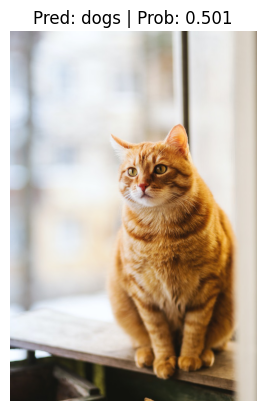

In [28]:
IMAGE_PATH = "/content/cat.jpg"
pred_and_plot_image(model = model_0,
                                class_names = class_names,
                                image_path = IMAGE_PATH,
                                device = device)

range(0, 5)


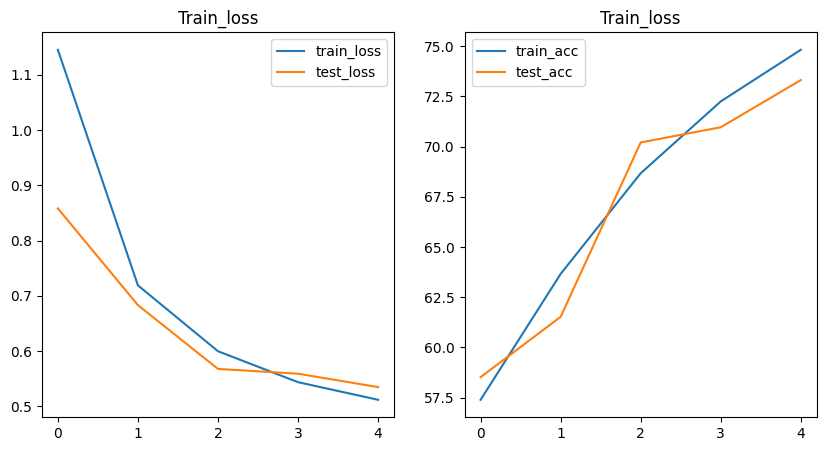

In [35]:

import matplotlib.pyplot as plt

epochs = range(len(model_0_pd["train_loss"]))
print(epochs)
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.plot(epochs, model_0_pd["train_loss"], label="train_loss")
plt.plot(epochs, model_0_pd["test_loss"], label="test_loss")
plt.title("Train_loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, model_0_pd["train_acc"], label="train_acc")
plt.plot(epochs, model_0_pd["test_acc"], label="test_acc")
plt.title("Train_loss")
plt.legend()